#Tools and Techniques for Combatting Cyber Radicalisation
by Matthew Redrup

Facilitator: Bazlur Rashid

##**Project Deliverable** Classification Model for classifying Tweets as from moderate, far-right or far-left representatives
Code is adapted from the fast.ai video tutorial by Zachary Mueller (2020) available on YouTube here https://www.youtube.com/watch?v=hfcqvWmQ1Jw The code is not published online.

In [1]:
# install libraries needed - This will also mount the gdrive where the data set is stored
!pip install -Uqq fastbook
!pip install fastdot
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai import *
from fastai.tabular.all import *
from fastai.text.all import *
from IPython.display import display,HTML
from sklearn.model_selection import train_test_split
from fastai.text.all import *
from fastdot import *

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 5.9 MB/s 
     |████████████████████████████████| 186 kB 69.8 MB/s 
     |████████████████████████████████| 1.2 MB 56.0 MB/s 
     |████████████████████████████████| 56 kB 5.6 MB/s 
     |████████████████████████████████| 51 kB 443 kB/s 
Mounted at /content/gdrive


In [2]:
# Move to location of the data set 
%cd "/content/gdrive/MyDrive/Colab Notebooks/"

/content/gdrive/MyDrive/Colab Notebooks


In [3]:
%cp -r 'ProjectFiles' /content/sample_data

In [4]:
path = Path('ProjectFiles')

In [5]:
# Read the data set and convert into a data frame
df = pd.read_csv('fardata.csv')
df.head()

,Unnamed: 0,username,label,tweet,name
0,0,USFreedomFront,far-right,@luthersserbe How is anyone a practicing Protestant today? The tens of thousands of Protestant denominations that have been all formed over the last few hundred years have dragged the Christian name through the mud. The only true choice is between Catholic or Orthodox.,Freedom Front
1,1,USFreedomFront,far-right,@joelockhart @CawthornforNC Shouldn’t be surprised that an old white CNN political analyst casually throws around politically motivated serial sexual harassment claims with no evidence. How do you live with yourself?,Freedom Front
2,2,USFreedomFront,far-right,"@IdealPatricia He’s a politician, not our king",Freedom Front
3,3,USFreedomFront,far-right,@AF_ZoomerDaily Return to tradition,Freedom Front
4,4,USFreedomFront,far-right,@Timelord420 You also don’t have control of your government but your told you do. And your told there’s free press and freedom of speech but the press is run by a handful of capitalists that censor dissidents.,Freedom Front


In [6]:
# Tidy the data set and add random split into training and validation set
cat_names = ['username', 'tweet', 'name']
cont_names = []
procs = [Categorify, FillMissing, Normalize]
y_names = 'label'
splits = RandomSplitter()(range_of(df))

In [7]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, splits=splits)

In [8]:
to.train.xs.iloc[:3]

,username,tweet,name
861,3,2054,35
228,42,757,11
3213,39,2872,18


In [9]:
to.train.ys.iloc[:3]

,label
861,1
228,1
3213,2


In [10]:
from IPython.utils import io as io_p

In [11]:
def get_b_w(t):
    best = round(t.best*1000, 2)
    worst = round(t.worst*1000, 2)
    return best, worst

In [12]:
def get_avg(a, b, dl):
    best = round(a/len(dl), 2)
    worst = round(b/len(dl), 2)
    return best, worst

In [13]:
dls = to.dataloaders(bs=128, device='cpu')

In [14]:
# Redirect where print goes to for easier reading of output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
print(f'Type = NumPy\nDevice = {dls.device}\nBatch Size = {dls.bs}') # Print device and batch size
with io_p.capture_output() as captured: # Hide %timeit output
    t = %timeit -o next(iter(dls.train)) # Time getting first batch
    best, worst = get_b_w(t) # Round
print(f'First Batch:\n\t`train`: Best: {best}ms, Worst: {worst}ms')
with io_p.capture_output() as captured:
    t = %timeit -o next(iter(dls.valid))
    best, worst = get_b_w(t)
print(f'\t`valid`: Best: {best}ms, Worst: {worst}ms')
with io_p.capture_output() as captured:
    t = %timeit -o for _ in dls.train: pass # Time going over all batches
    best, worst = get_b_w(t)
print(f'All Batches:\n\t`train`: Best: {best}ms, Worst: {worst}ms')
b_t,w_t = get_avg(best, worst, dls.train)
with io_p.capture_output() as captured:
    t = %timeit -o for _ in dls.valid: pass
    best, worst = get_b_w(t)
print(f'\t`valid`: Best: {best}ms, Worst: {worst}ms')
b_v,w_v = get_avg(best, worst, dls.valid)
print(f'Average Per Batch:\n\t`train`: Best: {b_t}ms/batch, Worst: {w_t}ms/batch')
print(f'\t`valid`: Best: {b_v}ms/batch, Worst: {w_v}ms/batch')
out = new_stdout.getvalue()
sys.stdout = old_stdout

In [15]:
print(out)

Type = NumPy
Device = cpu
Batch Size = 128
First Batch:
	`train`: Best: 4.7ms, Worst: 26.21ms
	`valid`: Best: 2.5ms, Worst: 2.64ms
All Batches:
	`train`: Best: 56.99ms, Worst: 59.13ms
	`valid`: Best: 14.46ms, Worst: 14.71ms
Average Per Batch:
	`train`: Best: 2.48ms/batch, Worst: 2.57ms/batch
	`valid`: Best: 2.41ms/batch, Worst: 2.45ms/batch



In [16]:
dls.device = 'cuda'

In [17]:
# Redirect where print goes to
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
print(f'Type = fastai\nDevice = {dls.device}\nBatch Size = {dls.bs}') # Print device and batch size
with io_p.capture_output() as captured: # Hide %timeit output
    t = %timeit -o next(iter(dls.train)) # Time getting first batch
    best, worst = get_b_w(t) # Round
print(f'First Batch:\n\t`train`: Best: {best}ms, Worst: {worst}ms')
with io_p.capture_output() as captured:
    t = %timeit -o next(iter(dls.valid))
    best, worst = get_b_w(t)
print(f'\t`valid`: Best: {best}ms, Worst: {worst}ms')
with io_p.capture_output() as captured:
    t = %timeit -o for _ in dls.train: pass # Time going over all batches
    best, worst = get_b_w(t)
print(f'All Batches:\n\t`train`: Best: {best}ms, Worst: {worst}ms')
b_t,w_t = get_avg(best, worst, dls.train)
with io_p.capture_output() as captured:
    t = %timeit -o for _ in dls.valid: pass
    best, worst = get_b_w(t)
print(f'\t`valid`: Best: {best}ms, Worst: {worst}ms')
b_v,w_v = get_avg(best, worst, dls.valid)
print(f'Average Per Batch:\n\t`train`: Best: {b_t}ms/batch, Worst: {w_t}ms/batch')
print(f'\t`valid`: Best: {b_v}ms/batch, Worst: {w_v}ms/batch')
out = new_stdout.getvalue()
sys.stdout = old_stdout

In [18]:
print(out)

Type = fastai
Device = cuda
Batch Size = 128
First Batch:
	`train`: Best: 4.77ms, Worst: 7.74ms
	`valid`: Best: 2.48ms, Worst: 2.72ms
All Batches:
	`train`: Best: 57.35ms, Worst: 65.87ms
	`valid`: Best: 14.44ms, Worst: 14.66ms
Average Per Batch:
	`train`: Best: 2.49ms/batch, Worst: 2.86ms/batch
	`valid`: Best: 2.41ms/batch, Worst: 2.44ms/batch



###Tokenization
The data is tokenized to turn it into a form that is easier for the engine to process when training the language model. This will normalize words in case such as where they have been capitolized at the start of a sentence. 

In [19]:
# Tokenize the text for training the language model
dls = TextDataLoaders.from_df(df, text_col='tweet', label_col='label', seed=1)
dls.show_batch(max_n=5)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj if your home or business was xxunk in xxmaj hurricane xxmaj ida , you may be xxunk for federal assistance . xxmaj my office is hosting a xxmaj hurricane xxmaj ida xxmaj recovery xxmaj xxunk with xxup fema , xxup xxunk , and xxup xxunk on xxmaj tuesday , 10 / 5 , at 6 xxup pm to answer your questions . xxmaj click here to register : https : / / t.co / xxunk https : / / t.co / xxunk",moderate
1,"xxbos xxmaj today xxmaj tom & & i xxunk the 9 / 11 memorial ceremony at the xxmaj xxunk xxunk . xxmaj this moving event was organized by the xxup xxunk at xxmaj xxunk xxmaj high xxmaj school & & directed by xxmaj xxunk . xxmaj xxunk . xxmaj xxunk xxmaj xxunk . xxmaj it was a xxunk reminder of the xxunk , courage , and xxunk of that terrible day 20 years ago . https : / / t.co / xxunk",moderate
2,"xxbos "" regardless , xxmaj brown ’s xxunk for the upcoming release of his memoirs , which will be given the xxunk treatment in a xxunk he ’s working on with actor xxmaj xxunk @winter of xxmaj bill & & xxmaj xxunk xxunk . xxmaj also coming up is xxmaj brown ’s trial , which — as if by design — is set for xxmaj xxunk . 5 "" xxmaj hello , @mpfed https : / / t.co / xxunk",far-left
3,"xxbos 🚨 virginians , we are xxunk an important election . xxmaj do n’t forget : ⬇ ️ 9 / xxunk xxmaj in person early voting begins 10 / xxunk xxmaj deadline to xxmaj register to xxmaj vote 10 / xxunk xxmaj deadline to xxunk xxmaj vote xxmaj by xxmaj mail xxmaj ballot 10 / 23 & & 10 / xxunk xxmaj saturday xxmaj voting xxmaj dates 11 / xxunk xxmaj election xxmaj day https : / / t.co / xxunk",moderate
4,"xxbos xxup fbi / xxup xxunk cooperator xxmaj neal xxmaj rauhauser is xxunk proud of using the "" # xxmaj anonymous "" # epikfail to discredit me ( latest email , left ) xxmaj but can he top his 2012 bid , under xxup fbi xxup xxunk xxmaj daniel xxmaj xxunk , to ensure xxmaj i 'd be denied bond over his own crimes ? ( upcoming memoirs from xxunk , right ) https : / / t.co / xxunk",far-left


In [20]:
# Batch data for processing
data_lm = TextDataLoaders.from_csv(path, 'fardata.csv', text_col='tweet', is_lm=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
data_lm.show_batch()

,text,text_
0,"xxbos xxmaj think of xxunk games all you want , but at least they care about their xxunk . xxmaj or at least more than the xxunk xxunk of xxunk with xxunk to xxunk new xxunk . xxmaj imagine playing xxmaj dark xxmaj souls 3 and you have to pay 4 xxunk for xxmaj xxunk 's xxunk . xxbos @lelulolololol xxmaj someone needs to tell that horse xxunk to get a xxunk","xxmaj think of xxunk games all you want , but at least they care about their xxunk . xxmaj or at least more than the xxunk xxunk of xxunk with xxunk to xxunk new xxunk . xxmaj imagine playing xxmaj dark xxmaj souls 3 and you have to pay 4 xxunk for xxmaj xxunk 's xxunk . xxbos @lelulolololol xxmaj someone needs to tell that horse xxunk to get a xxunk on"
1,those involved with this illegal xxmaj admin need to be removed to xxmaj gitmo as the enemy xxunk that they are and xxunk so they can do no more harm like the xxunk xxunk they are folks . xxmaj restore the xxunk xxmaj president who was actually elected . xxmaj give him 8 xxunk to restore us . xxbos @paleocon_dalton i want a red dead xxunk play through tbh xxbos xxunk @zoopwolf,involved with this illegal xxmaj admin need to be removed to xxmaj gitmo as the enemy xxunk that they are and xxunk so they can do no more harm like the xxunk xxunk they are folks . xxmaj restore the xxunk xxmaj president who was actually elected . xxmaj give him 8 xxunk to restore us . xxbos @paleocon_dalton i want a red dead xxunk play through tbh xxbos xxunk @zoopwolf xxmaj
2,in there looking like this not xxunk wtf is happening xxbos xxmaj let them know that the public behavior of their xxunk makes our communities unsafe . xxmaj xxunk xxunk below . xxmaj phone : xxunk - xxunk - xxunk xxmaj xxunk : https : / / t.co / xxunk xxmaj xxunk xxmaj business : https : / / t.co / xxunk ( option to leave a review is on the right,there looking like this not xxunk wtf is happening xxbos xxmaj let them know that the public behavior of their xxunk makes our communities unsafe . xxmaj xxunk xxunk below . xxmaj phone : xxunk - xxunk - xxunk xxmaj xxunk : https : / / t.co / xxunk xxmaj xxunk xxmaj business : https : / / t.co / xxunk ( option to leave a review is on the right hand
3,: / / t.co / xxunk xxbos xxmaj could the xxmaj taliban xxmaj xxunk xxmaj become a xxmaj xxunk xxmaj issue for the xxmaj far xxmaj right ? < < xxunk xxunk how xxunk of far right in xxup us & & xxmaj xxunk celebrate xxmaj taliban at same time as others whip up xxunk of xxmaj afghan immigrants https : / / t.co / xxunk xxbos @goosefrenusa xxmaj that ’s xxunk,/ / t.co / xxunk xxbos xxmaj could the xxmaj taliban xxmaj xxunk xxmaj become a xxmaj xxunk xxmaj issue for the xxmaj far xxmaj right ? < < xxunk xxunk how xxunk of far right in xxup us & & xxmaj xxunk celebrate xxmaj taliban at same time as others whip up xxunk of xxmaj afghan immigrants https : / / t.co / xxunk xxbos @goosefrenusa xxmaj that ’s xxunk bro
4,"into a taxing the middle working class . xxbos xxunk xxmaj you 're exactly right . xxmaj the xxunk does n't exist , but the xxunk , and the amount of folx wanting this , xxunk me . xxbos @hornyy_i i am xxunk an important one here https : / / t.co / xxunk xxbos @yobazoomer xxunk xxmaj twitter does n’t want baby xxunk to have xxunk ! xxmaj that ’s why","a taxing the middle working class . xxbos xxunk xxmaj you 're exactly right . xxmaj the xxunk does n't exist , but the xxunk , and the amount of folx wanting this , xxunk me . xxbos @hornyy_i i am xxunk an important one here https : / / t.co / xxunk xxbos @yobazoomer xxunk xxmaj twitter does n’t want baby xxunk to have xxunk ! xxmaj that ’s why they"
5,"but xxunk on a few of the xxunk of actors that xxup mw xxunk . a xxunk of chat xxunk , individual xxunk , and memes : xxbos @kingicespike @punishedtristan xxunk xxmaj the fuck have i xxunk upon ? xxbos xxmaj i ’m a big xxunk fan xxbos i love # xxunk because this is where the xxunk are at :) https : / / t.co / xxunk xxbos xxunk @libbyinphilly xxunk","xxunk on a few of th

###Numericalization
The data set is numericalised to create a vocabulary for training the language model.

In [22]:
# Numericalization
data_lm.vocab[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 '.']

In [23]:
data_lm.numericalize

Numericalize:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes

In [24]:
data_lm.tokenizer

Tokenizer:
encodes: (Path,object) -> encodes
(str,object) -> encodes
decodes: (object,object) -> decodes

In [25]:
data_lm.rules

[<function fastai.text.core.fix_html>,
 <function fastai.text.core.replace_rep>,
 <function fastai.text.core.replace_wrep>,
 <function fastai.text.core.spec_add_spaces>,
 <function fastai.text.core.rm_useless_spaces>,
 <function fastai.text.core.replace_all_caps>,
 <function fastai.text.core.replace_maj>,
 <function fastai.text.core.lowercase>]

In [26]:
data_lm.vocab[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 '.']

In [27]:
data_lm.o2i.items()

dict_items([('xxunk', 0), ('xxpad', 1), ('xxbos', 2), ('xxeos', 3), ('xxfld', 4), ('xxrep', 5), ('xxwrep', 6), ('xxup', 7), ('xxmaj', 8), ('.', 9), ('/', 10), ('the', 11), (',', 12), ('to', 13), ('and', 14), ('a', 15), ('of', 16), (':', 17), ('i', 18), ('https', 19), ('t.co', 20), ('is', 21), ('in', 22), ('that', 23), ('"', 24), ('it', 25), ('you', 26), ('for', 27), ('this', 28), ('-', 29), ('on', 30), ("'s", 31), ('?', 32), ('with', 33), ('are', 34), ('do', 35), ('not', 36), ('have', 37), ("n't", 38), ('be', 39), ('they', 40), ('was', 41), ('as', 42), ('me', 43), ('who', 44), ('!', 45), ('but', 46), ('all', 47), ('my', 48), ('from', 49), ('people', 50), ('or', 51), ('at', 52), ('we', 53), ('about', 54), ('their', 55), ('by', 56), ('so', 57), ('he', 58), ('if', 59), ('no', 60), ('just', 61), ('&', 62), ('what', 63), ('your', 64), ('an', 65), ('like', 66), ('’s', 67), ('how', 68), ('will', 69), ('has', 70), ('…', 71), ('up', 72), ('right', 73), ('one', 74), ('more', 75), (')', 76), ('('

In [28]:
tweet_lm = DataBlock(blocks=TextBlock.from_df('tweet', is_lm=True),
                     get_x=ColReader('text'),
                     splitter=RandomSplitter(0.1))

In [29]:
dls = tweet_lm.dataloaders(df, bs=64, seq_len=72)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [30]:
dls.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj my xxunk got into a car xxunk with my xxunk this morning xxmaj good mornin ' xxbos xxunk xxmaj question is not about vaccines . xxbos xxunk and i visited the @fema xxmaj disaster xxmaj recovery xxmaj center in xxmaj downingtown , which has already helped xxunk families . xxmaj i ’m thankful for everyone helping xxunk our residents through this process , and i continue to encourage our residents","xxmaj my xxunk got into a car xxunk with my xxunk this morning xxmaj good mornin ' xxbos xxunk xxmaj question is not about vaccines . xxbos xxunk and i visited the @fema xxmaj disaster xxmaj recovery xxmaj center in xxmaj downingtown , which has already helped xxunk families . xxmaj i ’m thankful for everyone helping xxunk our residents through this process , and i continue to encourage our residents to"
1,"a xxunk and xxunk plot by a former xxunk for the xxmaj proud xxmaj boys was found murdered in xxmaj el xxmaj xxunk , xxmaj xxunk , earlier this month . https : / / t.co / xxunk xxbos @punishedspook xxmaj it be me 😎 xxbos xxmaj xxunk : xxunk xxunk xxunk esta xxunk ! ⬇ ️ xxbos xxmaj many of us are desperate for answers to the xxunk situation in","xxunk and xxunk plot by a former xxunk for the xxmaj proud xxmaj boys was found murdered in xxmaj el xxmaj xxunk , xxmaj xxunk , earlier this month . https : / / t.co / xxunk xxbos @punishedspook xxmaj it be me 😎 xxbos xxmaj xxunk : xxunk xxunk xxunk esta xxunk ! ⬇ ️ xxbos xxmaj many of us are desperate for answers to the xxunk situation in xxmaj"
2,"/ / t.co / xxunk xxbos xxmaj if you ’re coming to the show tonight with @davechappelle and i at @stubbsaustin get there early for the covid test ! xxunk xxunk https : / / t.co / xxunk xxbos xxmaj my statement after the u.s - xxunk xxunk against xxup xxunk - k , the xxmaj xxunk xxmaj state xxunk that claimed responsibility for the suicide bombing outside xxmaj kabul xxunk :","/ t.co / xxunk xxbos xxmaj if you ’re coming to the show tonight with @davechappelle and i at @stubbsaustin get there early for the covid test ! xxunk xxunk https : / / t.co / xxunk xxbos xxmaj my statement after the u.s - xxunk xxunk against xxup xxunk - k , the xxmaj xxunk xxmaj state xxunk that claimed responsibility for the suicide bombing outside xxmaj kabul xxunk : https"


###Training the Language model
After tokenizing and numeracalizing the data then converting it to batches it can be used with transfer learning to retrain the language model trained on the Wikipedia data set (the default fast.ai language model for LSTM) using our Twitter data set.

In [31]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.3)

In [32]:
learn = learn.to_fp16()

SuggestedLRs(valley=0.0063095735386013985)

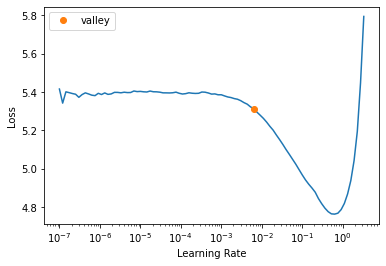

In [33]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,4.767924,4.414577,00:05


In [35]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,3.981602,3.966002,00:05


In [37]:
learn.save('fine_tuned')

Path('models/fine_tuned.pth')

In [38]:
text = 'Lets take back'
n_words = 20
n_sentences= 3

In [39]:
print('\n'.join(learn.predict(text, n_words) for _ in range(n_sentences)))

Lets take back some of it is taking up already 4 years . It 's quite very waste . i think between
Lets take back time to baby imagine . These are like an incredible moment . If someone else in
Lets take back a second , this time or included a lesson to you where awesome . i should u actively change your


In [40]:
learn.save_encoder('fine_tuned_enc')

### Using the language model to create a text classifier
Having used transfer learning to train the langauge model with our twitter dataset, our new language model should now be better suited for addressing the classification problem on our data set.

In [41]:
len(df)

3728

In [42]:
blocks = (TextBlock.from_df('tweet', seq_len=dls.seq_len, vocab=dls.vocab), CategoryBlock())

In [43]:
tweet_clas = DataBlock(blocks=blocks,
                       get_x=ColReader('text'),
                       get_y=ColReader('label'),
                       splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [44]:
# Create the data loaders
dls = tweet_clas.dataloaders(df, bs=64)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [45]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj if your home or business was xxunk in xxmaj hurricane xxmaj ida , you may be xxunk for federal assistance . xxmaj my office is hosting a xxmaj hurricane xxmaj ida xxmaj recovery xxmaj xxunk with xxup fema , xxup xxunk , and xxup xxunk on xxmaj tuesday , 10 / 5 , at 6 xxup pm to answer your questions . xxmaj click here to register : https : / / t.co / xxunk https : / / t.co / xxunk",moderate
1,"xxbos xxmaj today xxmaj tom & & i xxunk the 9 / 11 memorial ceremony at the xxmaj xxunk xxunk . xxmaj this moving event was organized by the xxup xxunk at xxmaj xxunk xxmaj high xxmaj school & & directed by xxmaj xxunk . xxmaj xxunk . xxmaj xxunk xxmaj xxunk . xxmaj it was a xxunk reminder of the xxunk , courage , and xxunk of that terrible day 20 years ago . https : / / t.co / xxunk",moderate
2,"xxbos xxup fbi / xxup xxunk cooperator xxmaj neal xxmaj rauhauser is xxunk proud of using the "" # xxmaj anonymous "" # epikfail to discredit me ( latest email , left ) xxmaj but can he top his 2012 bid , under xxup fbi xxup xxunk xxmaj daniel xxmaj xxunk , to ensure xxmaj i 'd be denied bond over his own crimes ? ( upcoming memoirs from xxunk , right ) https : / / t.co / xxunk",far-left


In [46]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn.load_encoder('fine_tuned_enc');

In [47]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.048929,0.896460,0.610738,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.895747,0.788277,0.648322,00:05
1,0.870129,0.739790,0.687248,00:05
2,0.831599,0.734686,0.684564,00:05
3,0.779608,0.651485,0.710067,00:05
4,0.712607,0.618363,0.735570,00:05
5,0.651361,0.630034,0.743624,00:05
6,0.602034,0.618265,0.753020,00:05
7,0.563687,0.606158,0.739597,00:05
8,0.537004,0.606960,0.746309,00:05
9,0.511010,0.614788,0.738255,00:05


In [48]:
learn.predict("Senate Democrats are now targeting people who have bought cryptocurrency.They think the tax code should treat the crypto ecosystem the same as it had been treating stockbrokers since 1954. That's not what I'd call progressive.")

('moderate', tensor(2), tensor([0.0711, 0.2424, 0.6865]))

In [49]:
learn.predict("Make no mistake: Access to high-speed Internet means access to opportunity.The Bipartisan Infrastructure bill will make a historic investment in our nation's broadband infrastructure.")

('moderate', tensor(2), tensor([0.0038, 0.0202, 0.9760]))

In [50]:
learn.predict("Critical Race Theory is racism. ")

('far-right', tensor(1), tensor([0.1074, 0.8471, 0.0454]))

In [51]:
learn.predict("No more white supremacy in this country ")

('far-left', tensor(0), tensor([0.8234, 0.1744, 0.0021]))

In [52]:
learn.export()

###Passing input to the model to get probabilities of political leaning
After exporting the model tweets can be passed to the model to get predicions

In [53]:
import ipywidgets as widgets

In [65]:
des1=widgets.Label('Paste tweet in the box below')
display(des1)
sample = widgets.Text()
display(sample)
btn=widgets.Button(description='check tweet')
display(btn)
res=widgets.Label()
display(res)
def check_tweet(b):
  x=(sample.value)
  res,_,probs=learn.predict(x)
  print(f"This appears to be {res}")
  print(f"The probabilities are far-left {probs[0].item():.2f}, far-right {probs[1].item():.2f} and moderate {probs[2].item():.2f}")
btn.on_click(check_tweet)



Label(value='Paste tweet in the box below')

Text(value='')

Button(description='check tweet', style=ButtonStyle())

Label(value='')

This appears to be far-left
The probabilities are far-left 0.62, far-right 0.26 and moderate 0.12
